# Denoise the S7 JPG Image dataset


### Defined a custom KL Loss Function

#### TF 2.0
* tf.dataset Input pipeline
* Functional API implementation of custom loss  (.add_loss() )

## U-Net patch approach
Eli Schwartz, Raja Giryes, and Alex M. Bronstein. "DeepISP: Learning End-to-End Image Processing Pipeline." arXiv preprint arXiv:1801.06724 (2018).

https://www.kaggle.com/knn165897/s7-isp-dataset![image.png](attachment:image.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from skimage.restoration import estimate_sigma
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
import os

/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/anthonyk/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [2]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
#print("GPU Available: {}".format(tf.test.is_gpu_available()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.0.0-beta1
Eager execution: True
Num GPUs Available:  8


In [3]:
# Start to build input pipeline from filepath dataset
#list_ds = tf.data.Dataset.list_files('./S7_JPG/*/*short*.jpg')
list_ds = tf.data.Dataset.list_files('./S7-ISP-Dataset/*/*short*.jpg')
train_list_ds = list_ds.take(90)        # List of Training Images
rest_list_ds = list_ds.skip(90)         # remainder
val_list_ds = rest_list_ds.take(10)     # List of Validation Images
test_list_ds = rest_list_ds.skip(10)    # List of Test Images

In [4]:
# How many files?
image_count = len([i for i in list_ds])
image_count_tr = len([i for i in train_list_ds])
image_count_val = len([i for i in val_list_ds])
image_count_test = len([i for i in test_list_ds])
print(f'short_JPG :{image_count}')
print(f'Training :{image_count_tr}')
print(f'Validation :{image_count_val}')
print(f'Test :{image_count_test}')

short_JPG :110
Training :90
Validation :10
Test :10


TF data API: how to efficiently sample small patches from images
https://stackoverflow.com/questions/48777889/tf-data-api-how-to-efficiently-sample-small-patches-from-images

You can achieve all that using the tf.data API by doing the following steps:

1. shuffle the filenames of the big images
2. read the big images
3. generate multiple patches from this image
4. shuffle again all these patches with a big enough buffer size (see this answer on buffer size). Adjusting the buffer size is a tradeoff between good shuffling and size of the cached patches
5. batch them
6. prefetch one batch


In [5]:
num_patches = 128                               # number of patches to extract from each image
patch_sz = 128                                  # patch size
patch_buf_sz = image_count_tr * num_patches     # shuffle patches from 'image_count_tr' different images
batch_sz = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.random.set_seed(42)

### Data Pipeline

In [6]:
def parse_fn(filename):
    ''' Takes "short" image filepath dataset.
    Returns processed "short" and "medium" image pairs'''
    
    image1 = read_decode(filename)   # Read 'short' image
    filename = tf.strings.regex_replace(filename, 'short','medium')
    image2 = read_decode(filename)   # Read 'medium' image

    return image1, image2

def read_decode(filename):
    '''Read Image Files and convert to image Tensors (0,1)'''
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

def get_patches(image1, image2, num_patches=100, patch_sz=64):
    '''Get Random Patches from image1 and corresponding patches from image2.
    Both images have the same dimensions'''
    patches1 = []
    patches2 = []
    for i in range(num_patches):
        image_height = 3024# image1.shape[0]
        image_width = 4032 # image1.shape[1]
        top_left_x = tf.random.uniform([1], maxval=image_width-patch_sz, dtype=tf.int32)
        top_left_y = tf.random.uniform([1], maxval=image_height-patch_sz, dtype=tf.int32)
        patch1 = tf.image.crop_to_bounding_box(image1, top_left_y[0], top_left_x[0], patch_sz, patch_sz)
        patch2 = tf.image.crop_to_bounding_box(image2, top_left_y[0], top_left_x[0], patch_sz, patch_sz)
        
        noise = tf.random.normal(shape=tf.shape(patch1), mean=0.0, stddev=1e-1, dtype=tf.float32)
        
        #patch1 = patch1 - tf.reduce_mean(patch1, axis=[-2, -3], keepdims=True)    # zero mean
        patch2 = patch2 - tf.reduce_mean(patch2, axis=[-2, -3], keepdims=True)    # zero mean
        patch1 = patch2 + noise     # Add noise to the 'Ground Truth (medium)' dataset to train on
    
        patches1.append(patch1)
        patches2.append(patch2)

    patches1 = tf.stack(patches1)    # patches from image1
    patches2 = tf.stack(patches2)    # patches from image2

    return patches1, patches2   # Noisy , Clean

# Lambda function to call inline
get_patches_fn = lambda image1, image2: get_patches(image1, image2, num_patches=num_patches, patch_sz=patch_sz)

def data_pipeline(list_ds, image_buf_sz, patch_buf_sz, batch_sz, patch_sz):
    '''Read and Process image files into batches of random patches from random files.
    dataset : Tensor file list
    Read image_buf_sz images from file,
    shuffle, convert to image Tensors, get random patches,
    shuffle patches, batch in to batch_sz'''
        
    list_ds = list_ds.shuffle(buffer_size=image_buf_sz)                  # Shuffle file list Tensor
    dataset = list_ds.map(parse_fn, num_parallel_calls=AUTOTUNE)         # Read and process files
    dataset = dataset.map(get_patches_fn, num_parallel_calls=AUTOTUNE)   # Get Patches
    dataset = dataset.unbatch()   
    dataset = dataset.shuffle(buffer_size=patch_buf_sz)                  # Shuffle Patches
    #dataset = dataset.batch(batch_sz).repeat().prefetch(1)              # Re-batch & Pre-fetch
    dataset = dataset.batch(batch_sz).prefetch(1)                        # Re-batch & Pre-fetch
    
    return dataset

In [7]:
train_ds = data_pipeline(train_list_ds, image_buf_sz=image_count_tr,
                                    patch_buf_sz=patch_buf_sz, batch_sz=batch_sz, patch_sz=patch_sz)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
val_ds = data_pipeline(val_list_ds, image_buf_sz=image_count_val,
                                    patch_buf_sz=patch_buf_sz, batch_sz=batch_sz, patch_sz=patch_sz)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

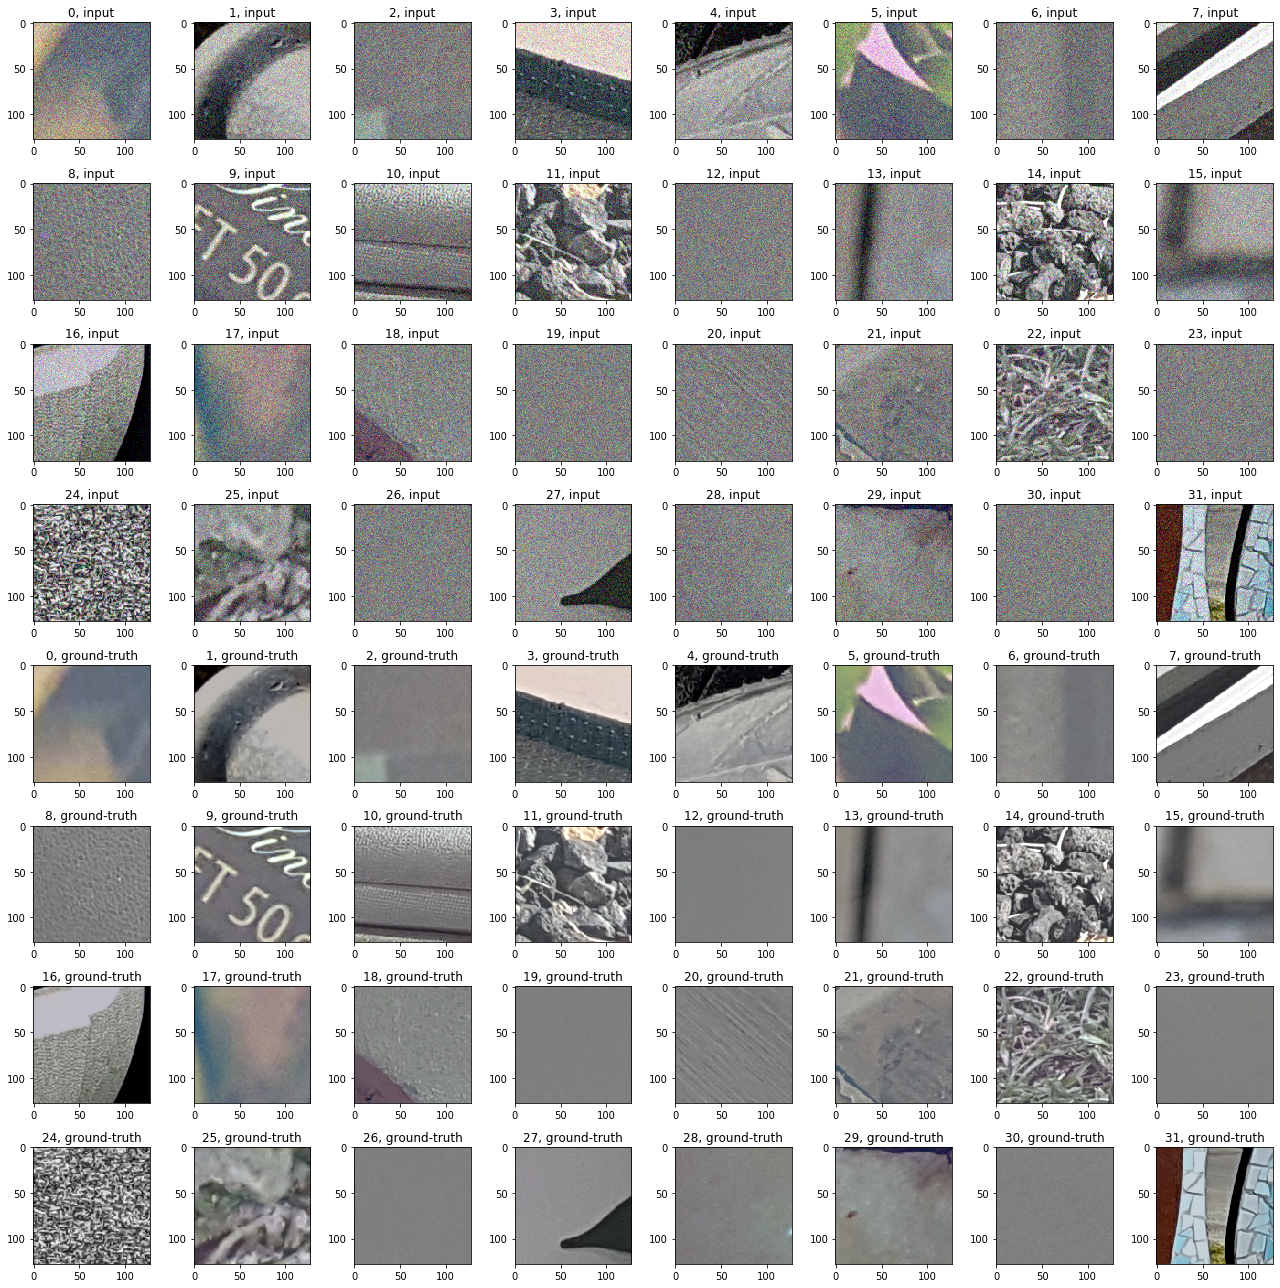

In [9]:
# Show 1 batch for visualisation purposes
plt.figure(figsize=(18,18))
for i in train_ds.take(1):
    for j in range(32):
        plt.subplot(8,8,j+1)
        plt.title(f'{j}, input')
        plt.imshow(0.5 + i[0][j])   # input
        plt.subplot(8,8,32+j+1)
        plt.title(f'{j}, ground-truth')
        plt.imshow(0.5 + i[1][j])   # ground-truth
plt.tight_layout()

## U-Net
Ronneberger, O., Fischer, P. and Brox, T. (2015) ‘U-Net: Convolutional Networks for Biomedical Image Segmentation’, in Lecture Notes in Computer Science (including subseries Lecture Notes in Artificial Intelligence and Lecture Notes in Bioinformatics), pp. 234–241. doi: 10.1007/978-3-319-24574-4_28.
http://link.springer.com/10.1007/978-3-319-24574-4_28

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose, concatenate
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import SGD

tf.keras.backend.clear_session()  # Reset Model


ip_layers = 3  # 3 for RGB, 1 for greyscale

def Unet():
    input_shape = (patch_sz,patch_sz,ip_layers)
    inputs = Input(input_shape)
    conv1 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv11')(inputs)
    conv1 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv12')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    conv2 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv21')(pool1)
    conv2 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv22')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)

    conv3 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv31')(pool2)
    conv3 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv32')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    conv4 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv41')(pool3)
    conv4 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv42')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)

    conv5 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv51')(pool4)
    conv5 = Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', name='conv52')(conv5)

    up6 = Conv2DTranspose(256, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu', name='conv_up6')(conv5)
    conv6 = concatenate([up6, conv4], name='cat6')
    conv6 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv61')(conv6)
    conv6 = Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', name='conv62')(conv6)

    up7 = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(conv6)
    conv7 = concatenate([up7, conv3], name='cat7')
    conv7 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv71')(conv7)
    conv7 = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='conv72')(conv7)

    up8 = Conv2DTranspose(64, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(conv7)
    conv8 = concatenate([up8, conv2], name='cat8')
    conv8 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv81')(conv8)
    conv8 = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='conv82')(conv8)

    up9 = Conv2DTranspose(32, kernel_size=(3, 3), strides=(2,2), padding='same', activation='relu')(conv8)
    conv9 = concatenate([up9, conv1], name='cat9')
    conv9 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv91')(conv9)
    conv9 = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='conv92')(conv9)

    conv10 = Conv2D(ip_layers, kernel_size=(3, 3), padding='same', activation='linear', name='conv10')(conv9)
    
    return Model(inputs=inputs, outputs=conv10)


In [16]:
#  tensorboard --logdir logs/scalars &
import os
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint 

root_logdir = os.path.join(os.curdir, "logs")
logdir =  os.path.join(root_logdir, datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=logdir,
                                  histogram_freq=1,
                                  write_images=False)
checkpoint_cb = ModelCheckpoint("model_checkpoint.h5")

## Custom Loss Function
* Use MSE between Input and Ground-truth for main Loss. GT can be Input (zero loss), Noisy input, Medium exposure Image etc...
* Add custom loss on Residual e.g. KLdiv


ref:
Géron, A., 2019. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems. O'Reilly Media.

In [17]:
model = Unet()
print(model.summary())


def custom_loss(y_true, y_pred):
    
    res = model.get_input_at(node_index=0) - model.get_output_at(node_index=-1)
    #res_mean = tf.reduce_mean(res, axis=[-2, -3], keepdims=True)  
    #res_std = tf.math.reduce_std(res, axis=[-2, -3], keepdims=True) 

    res_mean = tf.reduce_mean(res)   # single mean for RGB for now
    res_std = tf.math.reduce_std(res) 
    
    inp_noise = tf.reduce_sum(tf.image.total_variation(model.get_input_at(node_index=0)))/patch_sz/patch_sz
    op_noise = tf.reduce_sum(tf.image.total_variation(model.get_output_at(node_index=-1)))/patch_sz/patch_sz

    edges = tf.linspace(-0.1,0.1,100)
    res_histo = tfp.stats.histogram(res, edges)
    res_pdf = res_histo/tf.reduce_sum(res_histo)      # pdf sums to 1

    norm_dist = tfp.distributions.Normal(loc=0, scale=op_noise)  #
    norm_pdf = norm_dist.prob(edges[:-1])
    norm_pdf /= tf.reduce_sum(norm_pdf)

    residual_loss = 0.1*K.abs(res_mean) + 0.5*tf.keras.losses.kullback_leibler_divergence(norm_pdf, res_pdf)
    
    loss = tf.reduce_mean(tf.square(y_true-y_pred))
    
    return loss #+ 0.1*residual_loss

model.compile(loss=custom_loss, optimizer='adam')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv11 (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv12 (Conv2D)                 (None, 128, 128, 32) 9248        conv11[0][0]                     
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 64, 32)   0           conv12[0][0]                     
______________________________________________________________________________________________

## Train the Model

In [18]:
epochs = 200
steps_per_epoch = patch_buf_sz // batch_sz

In [ ]:
history = model.fit(train_ds, epochs=epochs, #steps_per_epoch=1,
                    validation_data=val_ds, validation_steps=steps_per_epoch//20,
                    callbacks=[tensorboard_callback])

Epoch 1/200
360/360 [==============================] - 44s 122ms/step - loss: 0.0012 - val_loss: 0.0000e+00
Epoch 2/200
360/360 [==============================] - 41s 115ms/step - loss: 5.1416e-04 - val_loss: 4.4917e-04
Epoch 3/200
360/360 [==============================] - 41s 115ms/step - loss: 4.6166e-04 - val_loss: 4.4180e-04
Epoch 4/200
360/360 [==============================] - 41s 115ms/step - loss: 4.4238e-04 - val_loss: 4.4095e-04
Epoch 5/200
360/360 [==============================] - 41s 115ms/step - loss: 4.2992e-04 - val_loss: 4.3845e-04
Epoch 6/200
359/360 [============================>.] - ETA: 0s - loss: 4.1996e-04

### Save the Model

In [15]:
# unet 001 : 0.5 centered input data
# unet 002 : 0 centered data, last unet layer (conv10), activation=linear
# unet 003 : Noisy (1E-1) / Clean pairs. MSE loss. Corresponds to OneNote: 'Denoise_S7_JPG MSE experiments' 7th Jan 2020
   # Updated save to run for 1500 epochs
# unet 004 : KL + MSE Loss on Noisy / Clean pairs. ~40 epochs
# unet 005 : Noisy (1E-3)/ Clean pairs. MSE loss (in custom_loss fn). 200 epochs. 20200114-172040/train (on Titan) for 200,
# 20200113-212401/validation for 1k
# unet 006 : Noisy (1E-2)/ Clean pairs. MSE loss (in custom_loss fn). 200 epochs. 20200114-201701/validation
# unet 007: Noisy (1E-1/ Clean pairs. MSE loss (in custom_loss fn). 200 epochs. 20200114-230106/train
# unet 008: Clean / Clean pairs. MSE loss (in custom_loss fn). 200 epochs. 20200115-192414/train
# unet 009: MSE + Residual Loss

model_version = 'Titan0009'
model_name = 'unet'
model_path = os.path.join('models',model_name, model_version+'model.h5')

In [16]:
model.save(model_path)

### Load the model if required

In [17]:
#model = tf.keras.models.load_model(model_path)
model = tf.keras.models.load_model(model_path, custom_objects={"custom_loss":custom_loss})
#model = tf.keras.models.load_model("model_checkpoint.h5")

# Predict

In [18]:
val_ex = next(iter(val_ds.take(1)))

In [19]:
pred_ar = model.predict(val_ex, steps=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


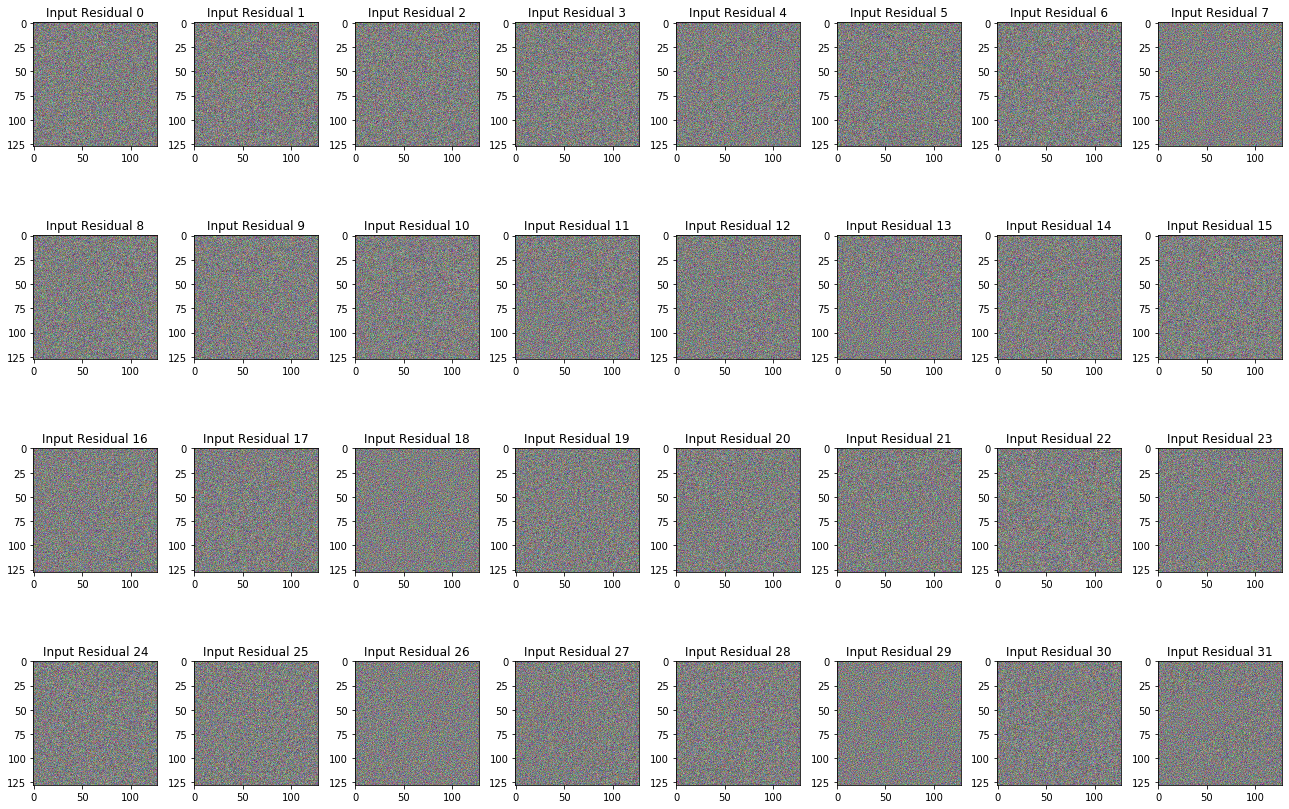

In [20]:
plt.figure(figsize=(18,12))

for j in range(32):
    plt.subplot(4,8,j+1)
    plt.title(f'Input Residual {j}')
    plt.imshow(0.5+pred_ar[j]-val_ex[0][j])
plt.tight_layout()

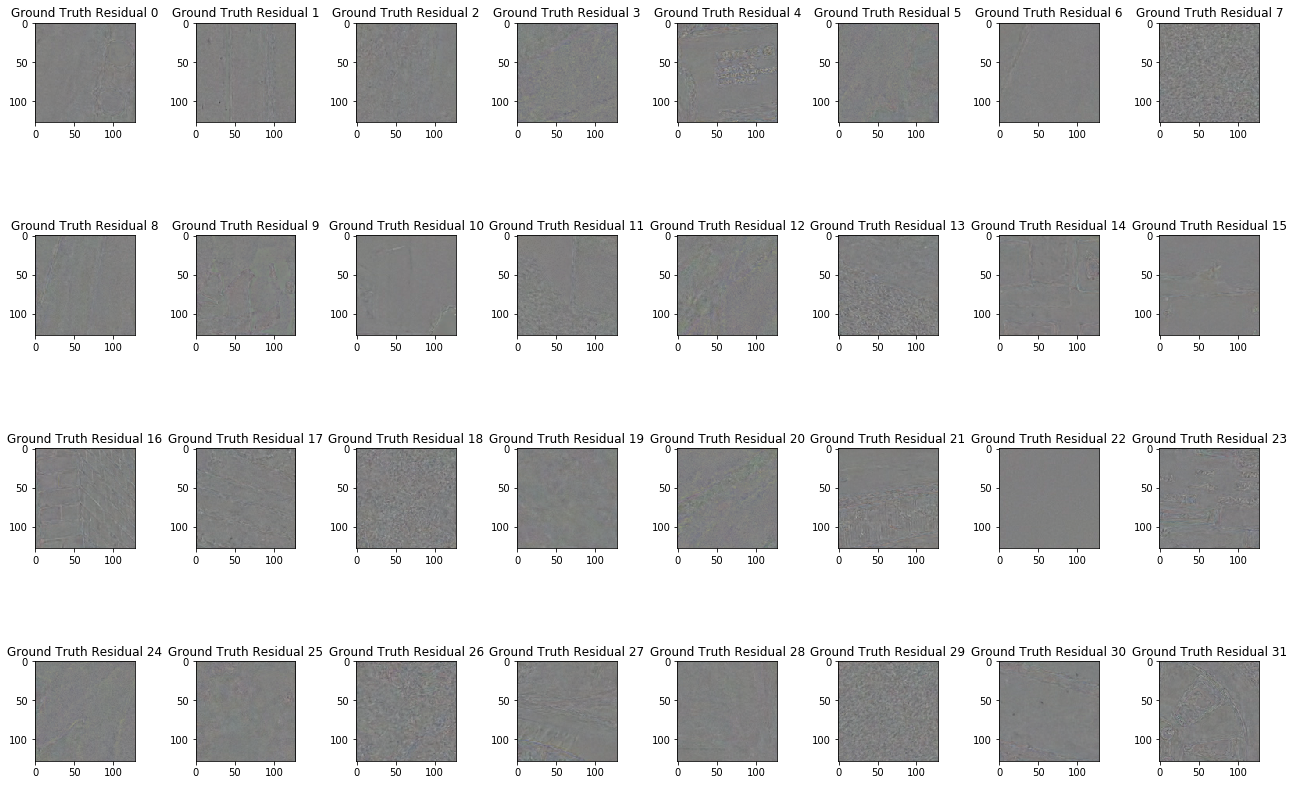

In [21]:
plt.figure(figsize=(18,12))

for j in range(32):
    plt.subplot(4,8,j+1)
    plt.title(f'Ground Truth Residual {j}')
    plt.imshow(0.5+pred_ar[j]-val_ex[1][j])
plt.tight_layout()

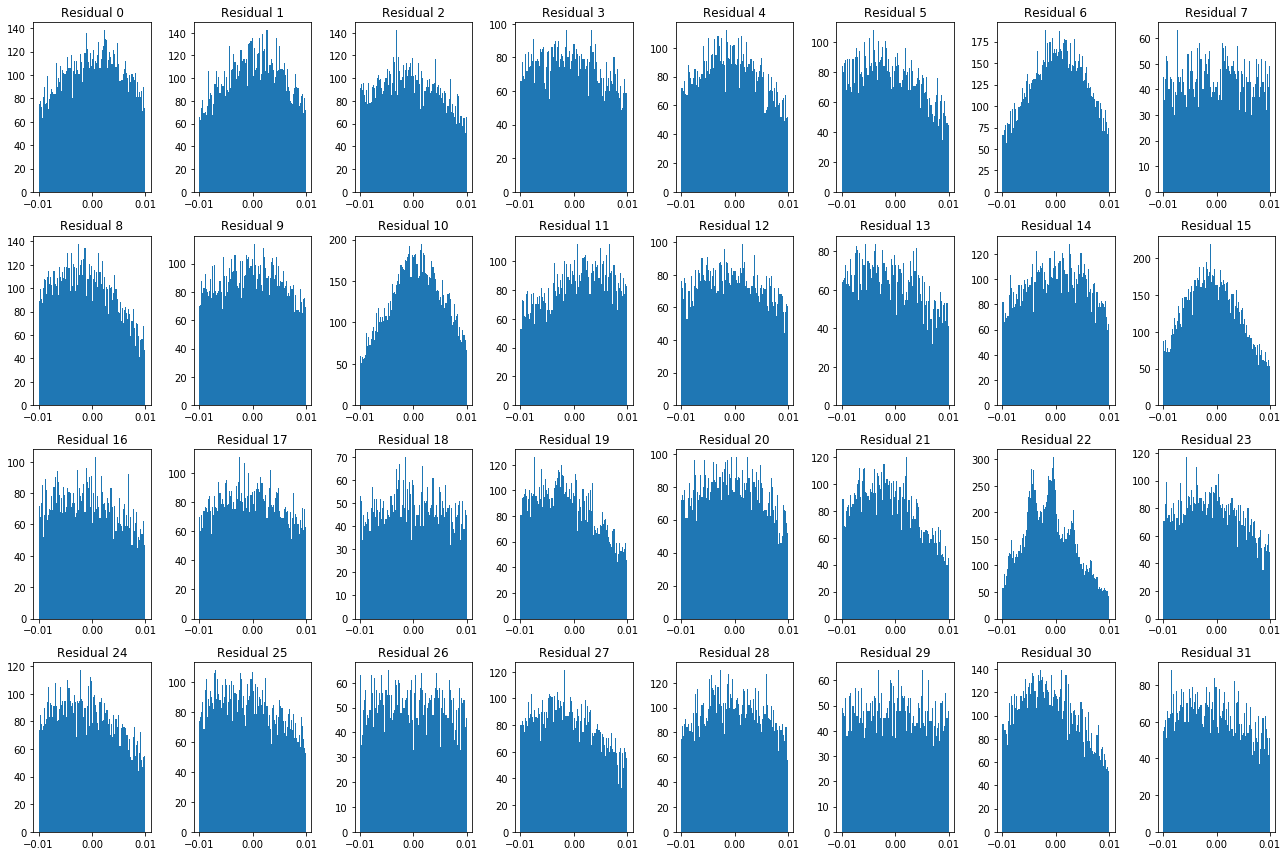

In [22]:
plt.figure(figsize=(18,12))

for j in range(32):
    plt.subplot(4,8,j+1)
    plt.title(f'Residual {j}')
    plt.hist(pred_ar[j].reshape(-1,3)[:,0]-val_ex[1][j].numpy().reshape(-1,3)[:,0], range=(-.01,.01),bins=100)
plt.tight_layout()


/home/anthonyk/.local/lib/python3.6/site-packages/skimage/restoration/_denoise.py:755: UserWarning: image is size 3 on the last axis, but multichannel is False.  If this is a color image, please set multichannel to True for proper noise estimation.
  warn(msg.format(image.shape[-1]))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with 

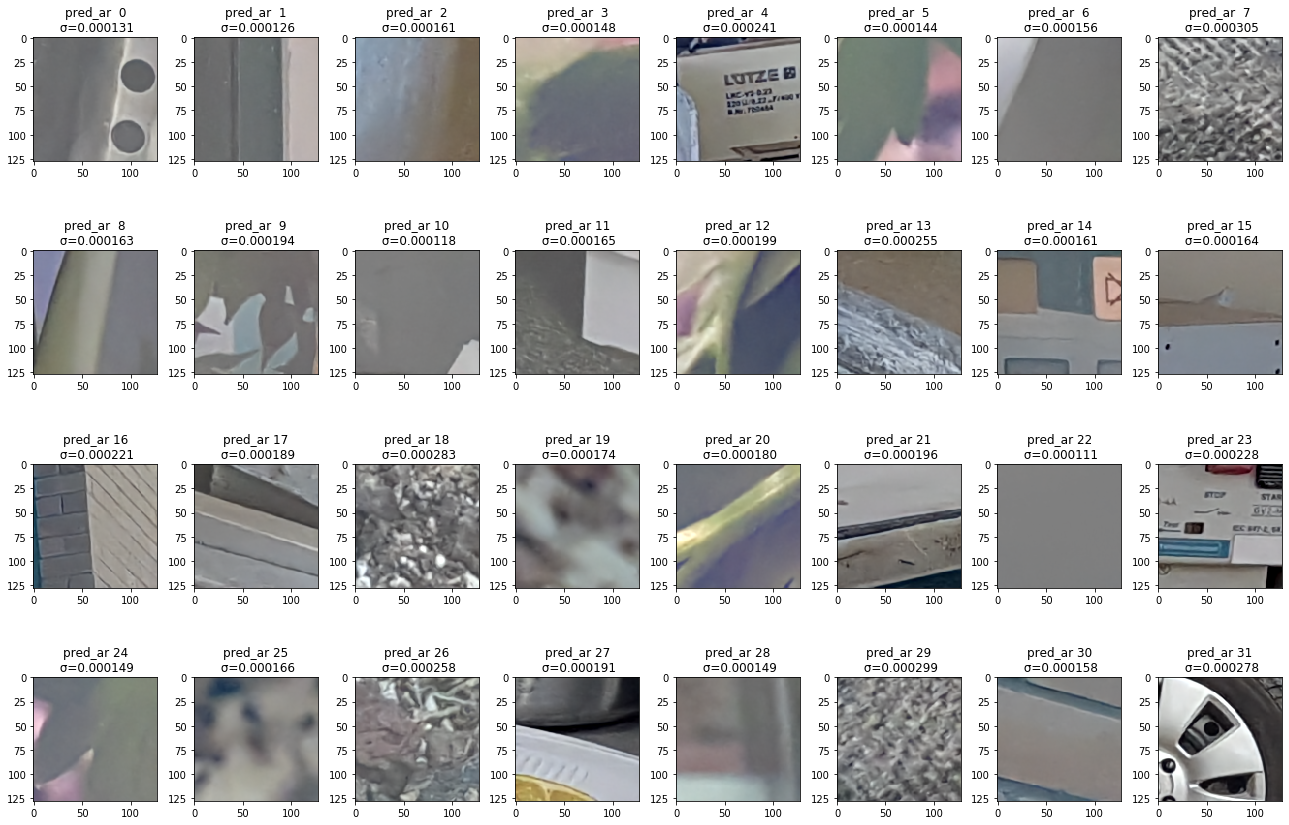

In [23]:
plt.figure(figsize=(18,12))

for j in range(32):
    plt.subplot(4,8,j+1)
    plt.title("pred_ar {:2d}\n σ={:4f}".format(j,estimate_sigma(pred_ar[j])))
    plt.imshow(0.5 + pred_ar[j])

plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

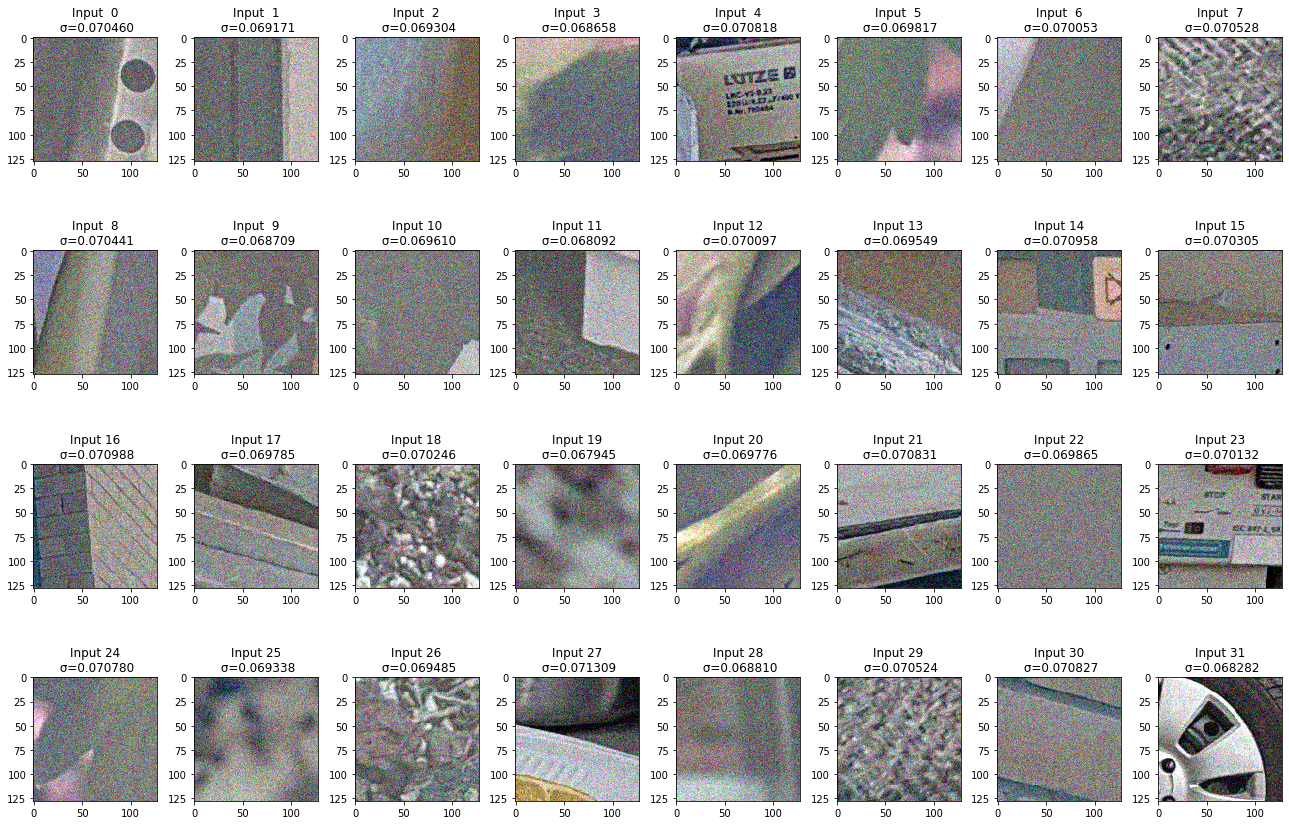

In [24]:
plt.figure(figsize=(18,12))

for j in range(32):
    plt.subplot(4,8,j+1)
    plt.title("Input {:2d}\n σ={:4f}".format(j,estimate_sigma(val_ex[0][j])))
    plt.imshow(0.5 + val_ex[0][j])

plt.tight_layout()

In [25]:
# PSNR vs [ip, gt, residual]
np.c_[tf.image.psnr(val_ex[0],pred_ar, max_val=2).numpy(),
      tf.image.psnr(val_ex[1],pred_ar, max_val=2).numpy(),
     10*np.log10(2/tf.math.reduce_variance((val_ex[0]-pred_ar),axis=[-1,-2,-3]))]

array([[26.110289, 43.389194, 23.100296],
       [26.093437, 43.27455 , 23.083761],
       [26.12349 , 42.60243 , 23.11347 ],
       [26.09555 , 41.76853 , 23.086359],
       [26.24927 , 38.917637, 23.239935],
       [26.09717 , 42.47835 , 23.089037],
       [26.08551 , 46.799835, 23.075228],
       [26.403635, 36.72913 , 23.393982],
       [26.050209, 43.668137, 23.040506],
       [26.093134, 41.7639  , 23.083227],
       [26.153046, 45.818085, 23.142748],
       [26.14845 , 41.45083 , 23.13944 ],
       [26.16058 , 41.062016, 23.154243],
       [26.2121  , 38.426563, 23.202353],
       [26.14155 , 42.74837 , 23.131678],
       [26.08086 , 45.517223, 23.070612],
       [26.197742, 40.180187, 23.188179],
       [26.096292, 40.50946 , 23.086716],
       [26.346272, 37.12494 , 23.336739],
       [26.08964 , 43.190037, 23.08081 ],
       [26.131947, 41.516617, 23.124882],
       [26.112364, 39.781776, 23.103638],
       [26.022205, 50.46583 , 23.01192 ],
       [26.21389 , 39.272224, 23.2

In [26]:
-10*np.log10(tf.math.reduce_mean(tf.math.square(val_ex[0]-pred_ar),axis=[-1,-2,-3]))

array([20.089691, 20.07284 , 20.102892, 20.074951, 20.22867 , 20.07657 ,
       20.06491 , 20.383036, 20.02961 , 20.072535, 20.132446, 20.127851,
       20.13998 , 20.1915  , 20.120953, 20.06026 , 20.177143, 20.075695,
       20.325672, 20.069042, 20.111347, 20.091764, 20.001606, 20.19329 ,
       20.068054, 20.07565 , 20.303818, 20.168537, 20.080662, 20.307285,
       20.100119, 20.273829], dtype=float32)

In [27]:
def PSNR(rgb1, rgb2):
    return 20*np.log10(255/(np.mean(pow(rgb1-rgb2,2))))

## Train with Custom Loss over image pairs

Note use of Generator to present batches
https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory


Also: https://stackoverflow.com/questions/39263002/calling-fit-multiple-times-in-keras
states that you can call .fit multiple times to continue training

Also:
https://stackoverflow.com/questions/58022713/tensorflow-2-0-custom-loss-function-with-multiple-inputs

and
https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough

## Analyse the Residual

## Examine Output

In [28]:
def PSNR(rgb1, rgb2):
    rgb1 = rgb1-rgb1.mean()
    rgb2 = rgb2-rgb2.mean()
    return np.mean(pow(rgb1-rgb2,2))
    return 10*np.log10(255/(np.mean(pow(rgb1-rgb2,2))))

* Reference: J. Immerkær, “Fast Noise Variance Estimation”, Computer Vision and Image Understanding, Vol. 64, No. 2, pp. 300-302, Sep. 1996 [PDF]
* https://stackoverflow.com/questions/2440504/noise-estimation-noise-measurement-in-image

In [29]:
from scipy.signal import convolve2d

def estimate_noise(I):
    '''I: grey scale image
    Out: Variance of image noise'''
    
    I = I.squeeze()  # remove last 1 dim if present
    
    H, W = I.shape

    M = np.array([[1, -2, 1],
       [-2, 4, -2],
       [1, -2, 1]])

    sigma = np.sum(np.sum(np.absolute(convolve2d(I, M))))
    sigma = sigma * np.sqrt(0.5 * np.pi) / (6 * (W-2) * (H-2))

    return sigma

### Examine the Residual
* Note **the Prediction is LESS NOISY thatn the groud-truth**
* This means noise reduction is inherent in the Network and not learned e.g. (Lempitsky, V., Vedaldi, A., & Ulyanov, D. (2018). Deep Image Prior. Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition, 9446–9454. https://doi.org/10.1109/CVPR.2018.00984)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


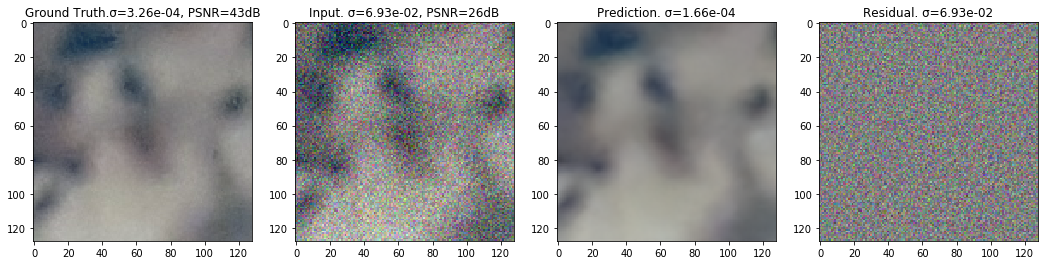

In [30]:
ind=25
plt.figure(figsize=(18,12))
plt.subplot(1,4,1)
plt.imshow(0.5+val_ex[1][ind])
plt.title('Ground Truth.σ={:4.2e}, PSNR={:2.0f}dB'.format(estimate_sigma(val_ex[1][ind]),
          tf.image.psnr(pred_ar[ind],val_ex[1][ind], max_val=2)))
plt.subplot(1,4,2)
plt.imshow(0.5+val_ex[0][ind])
plt.title('Input. σ={:4.2e}, PSNR={:2.0f}dB'.format(estimate_sigma(val_ex[0][ind]),
          tf.image.psnr(pred_ar[ind],val_ex[0][ind], max_val=2)))
plt.subplot(1,4,3)
plt.imshow(0.5+pred_ar[ind])
plt.title('Prediction. σ={:4.2e}'.format(estimate_sigma(pred_ar[ind])))
plt.subplot(1,4,4)
plt.imshow(0.5+val_ex[0][ind]-pred_ar[ind])
plt.title('Residual. σ={:4.2e}'.format(estimate_sigma(val_ex[0][ind]-pred_ar[ind])))
plt.show()

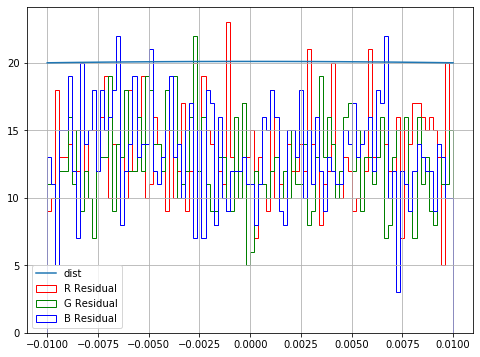

In [31]:
plt.figure(figsize=(8,6))

plt.hist(val_ex[0][ind].numpy().reshape(-1,3)[:,0] - pred_ar[ind].reshape(-1,3)[:,0],
         histtype='step', range=(-.01,.01), bins=100, label='R Residual', color='r')

plt.hist(val_ex[0][ind].numpy().reshape(-1,3)[:,1] - pred_ar[ind].reshape(-1,3)[:,1],
         histtype='step', range=(-.01,.01), bins=100, label='G Residual', color='g')

plt.hist(val_ex[0][ind].numpy().reshape(-1,3)[:,2] - pred_ar[ind].reshape(-1,3)[:,2],
         histtype='step', range=(-.01,.01), bins=100, label='B Residual', color='b')

from scipy.stats import norm
x = np.linspace(-0.01,0.01, num=100)
a = val_ex[0][ind].numpy().reshape(-1,3)[:,0] - pred_ar[ind].reshape(-1,3)[:,0]
d = norm.pdf(x, 0, a.std())
d = d*5
plt.plot(x,d,label = 'dist')

plt.legend()
plt.grid()
plt.show()

In [32]:
a = val_ex[1][ind].numpy().reshape(-1,3)[:,0] - pred_ar[ind].reshape(-1,3)[:,0]
print('Mean: ',a.mean())
print('Std: ',a.std())
print('PSNR Res: ',20*np.log10(2/a.std()))

Mean:  0.0023168167
Std:  0.014825501
PSNR Res:  42.600412609127


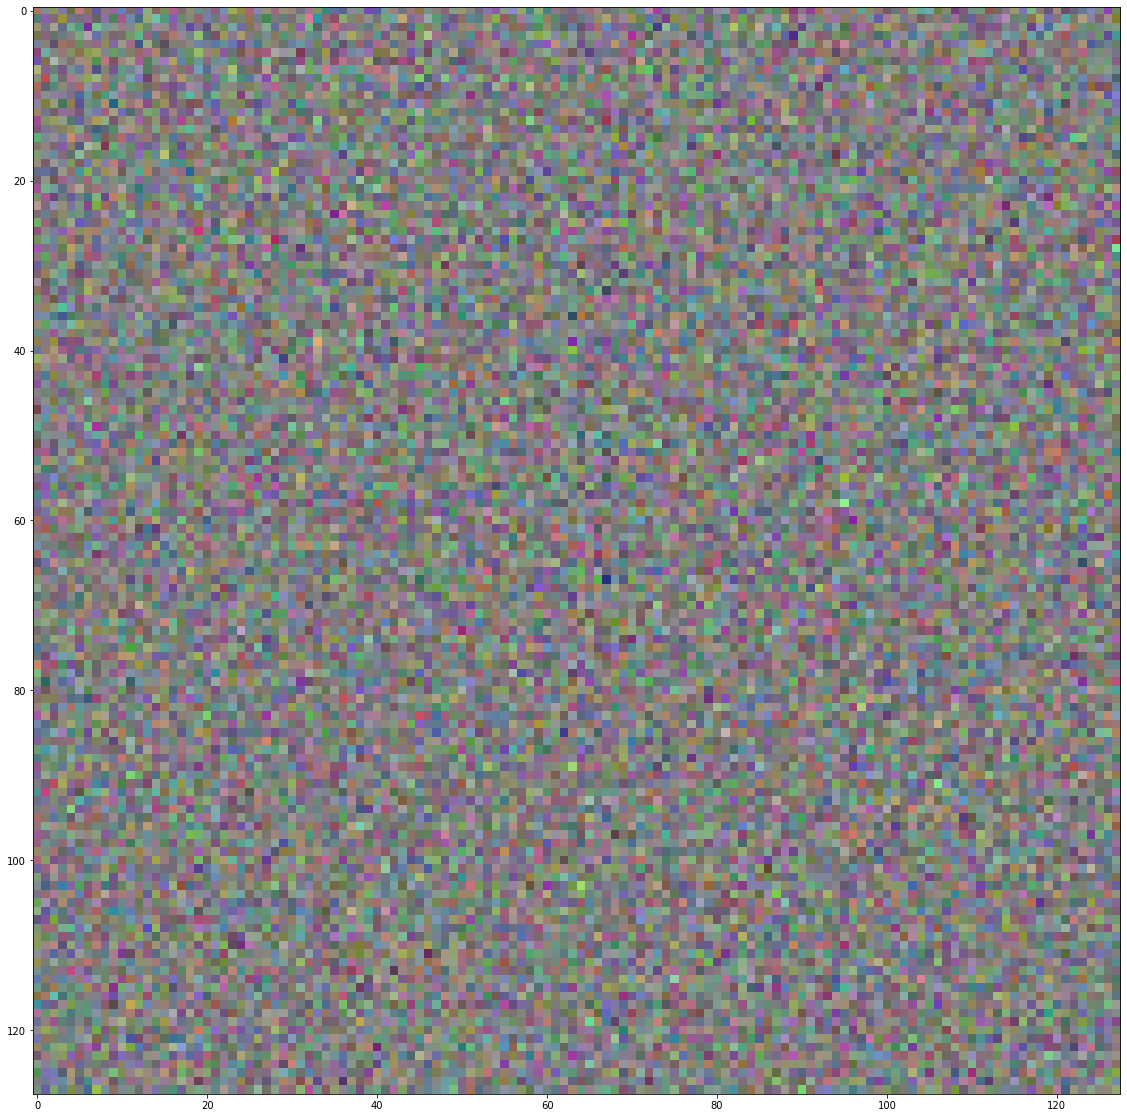

In [33]:
plt.figure(figsize=(20,20))
res = val_ex[0][ind]-pred_ar[ind]
plt.imshow(0.5+res)
plt.show()

In [34]:
res_mean = tf.reduce_mean(res)   # single mean for RGB for now
res_std = tf.math.reduce_std(res) 

edges = tf.linspace(-0.1,0.1,100)
res_histo = tfp.stats.histogram(res, edges)
res_pdf = res_histo/tf.reduce_sum(res_histo)      # pdf sums to 1

norm_dist = tfp.distributions.Normal(loc=0, scale=res_std)
norm_pdf = norm_dist.prob(edges[:-1])
norm_pdf /= tf.reduce_sum(norm_pdf)

residual_loss = K.square(res_mean) + tf.keras.losses.kullback_leibler_divergence(norm_pdf, res_pdf) 

In [35]:
tf.keras.losses.kullback_leibler_divergence(norm_pdf, res_pdf) 

<tf.Tensor: id=527883, shape=(), dtype=float32, numpy=0.0013482835>